In [32]:
#import packages
import re
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
#import data
tweet_dataset = pd.read_csv("data/emotion_twitter.csv", encoding ='ISO-8859-1',header=None)
type(tweet_dataset)

pandas.core.frame.DataFrame

In [3]:
#add names to columns
tweet_dataset.columns = ['sentiment','id','date','flag','user','text']

In [4]:
#remove some unecessary attributes
for i in ['flag','id','user','date']: 
    del tweet_dataset[i] 

In [5]:
#have some informations
tweet_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [6]:
#get classes set's of the target variable "emotion"
#0-sentiment negative
#4-sentiment positif
tweet_dataset.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [7]:
#display some negative and positive emotion tweet
tweet_dataset[tweet_dataset.sentiment == 0].head(10)   

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [8]:
tweet_dataset[tweet_dataset.sentiment == 4].head(10) 

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [9]:
#create cleaning method
def cleaning_tweet(tweet):
	#tweet = preprocess of a single tweet in form of string 
	#convert the tweet to lower case
    tweet=tweet.lower()
	#convert all urls to sting "URL"
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
	#convert all @username to "AT_USER"
    tweet = re.sub('@[^\s]+','AT_USER', tweet)
	#convert "#topic" to just "topic"
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
	#remove punctuation 
    tweet=re.sub("[^a-zA-Z]"," ",tweet)
   #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)
    
    tweet=tweet.lower()
    return (tweet)

tweet_dataset['text']=tweet_dataset['text'].apply(cleaning_tweet)

In [10]:
#the goal here is to tokenize in words and eliminate unwanted words and stemmatization and lemmatization
nltk.download('stopwords')

#initialise a list of stopwords for english language
stpw=set(stopwords.words('english'))
print(stpw)

{"shan't", "wasn't", 're', 'ain', 'further', 'couldn', 'or', 'through', 'hasn', 'was', 'd', 'wouldn', 'been', 't', 'themselves', 'other', "couldn't", 'too', 'this', 'll', 'hadn', 'of', 'don', 'can', 'didn', "you'll", 'm', "won't", 'that', 'to', 'each', 'off', 'have', 'he', "you've", 'how', 'wasn', 'had', 'you', 'in', 'what', 'for', 'on', 'do', 'under', 'be', 'isn', 'has', 'your', 'than', 'where', 'just', 'these', 'until', "don't", 'with', 'very', 'and', 'now', 'by', 'such', 'yours', 'doesn', 'during', 'no', 'which', 'does', "hadn't", 'a', 'yourselves', 'below', "should've", 'her', 's', 'should', 'who', 'down', 'being', "needn't", 'his', "wouldn't", 'own', "shouldn't", 'our', 'itself', 'we', 'not', 'more', 'but', 'needn', 'when', 'ma', 'why', 'most', "you'd", "isn't", 'did', 'if', 'yourself', 'about', 'there', 'so', 'having', 'some', "mustn't", 'himself', 'above', 'they', 'at', 'as', 'up', 'then', 'once', 'mustn', 'after', 'whom', 'hers', 'am', "aren't", "it's", 'its', 'won', 'herself',

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eya_g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#initialization of stemmer and lemmatizer
ps = PorterStemmer()
lem = WordNetLemmatizer()
def preprocess_tweet(tweet):
    tweet_words=word_tokenize(tweet) 
    filtered_sent=[]
    for w in tweet_words:
        if w not in stpw:
            filtered_sent.append(w)

    stemmed_words=[]
    for w in filtered_sent:
       stemmed_words.append(ps.stem(w))
       
    lemmatized_words=[]
    for w in stemmed_words:
       lemmatized_words.append(lem.lemmatize(w))     
    tweet=lemmatized_words
    return(tweet) 

In [12]:
nltk.download('wordnet')
#convert text as string
tweet_dataset['text']=tweet_dataset['text'].apply(preprocess_tweet)   

tweet_dataset['text']=[" ".join(tweet) for tweet in tweet_dataset['text'].values]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eya_g\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


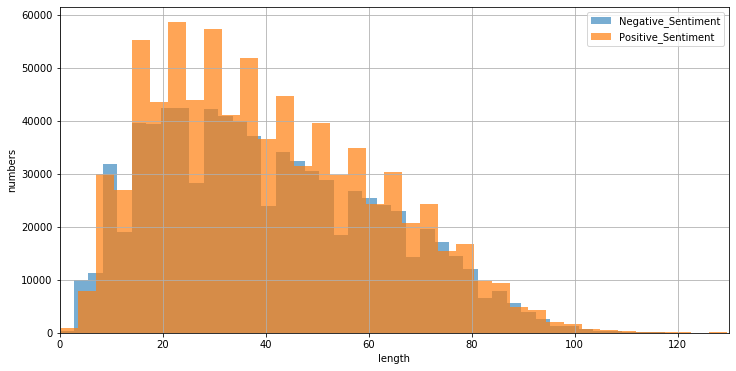

In [13]:
def length(tweet):    
    return len(tweet)

tweet_dataset['length']=tweet_dataset['text'].apply(length)

negative_sentiment=tweet_dataset[tweet_dataset['sentiment']==0]
positive_sentiment=tweet_dataset[tweet_dataset['sentiment']==4]

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 50
plt.hist(negative_sentiment['length'], alpha = 0.6, bins=bins, label='Negative_Sentiment')
plt.hist(positive_sentiment['length'], alpha = 0.7, bins=bins, label='Positive_Sentiment')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,130)
plt.grid()
plt.show()

In [14]:
#proceed to the transformation tf-idf
data = np.array(tweet_dataset.text)
label = np.array(tweet_dataset.sentiment)

In [15]:
#create matrix
tfv=TfidfVectorizer(sublinear_tf=True)
features=tfv.fit_transform(data)

vocab=tfv.fit(data)
features_dictionary = vocab.vocabulary_.items()

In [16]:
# init lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in features_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
tweet_vocab = pd.Series(count, index=vocab)

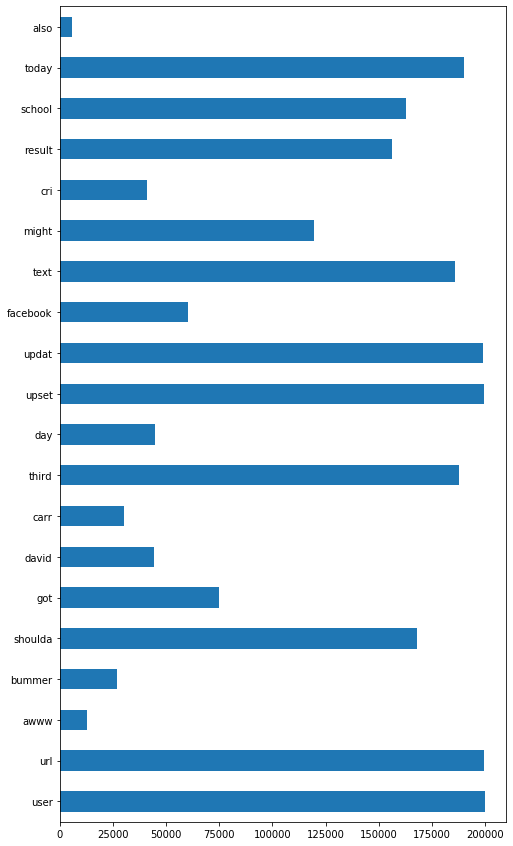

In [17]:
# presentation of the 20 first
top_vacab = tweet_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(8,15))

In [18]:
#select sample
N=label.shape[0]
n=int(N/100)
sample = np.random.randint(N, size=n)
features = features[sample]
label= label[sample]

In [19]:
#sample train_test
X_train, X_test, y_train, y_test = train_test_split(features,label, test_size=0.25, random_state=1234)

In [20]:
#construct naive bayesian model
mlp = MLPClassifier(hidden_layer_sizes=(10,),max_iter=70,solver='adam',verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.70696594
Iteration 2, loss = 0.66363808
Iteration 3, loss = 0.61625854
Iteration 4, loss = 0.56543607
Iteration 5, loss = 0.51732283
Iteration 6, loss = 0.47434258
Iteration 7, loss = 0.43742392
Iteration 8, loss = 0.40598970
Iteration 9, loss = 0.37926521
Iteration 10, loss = 0.35620728
Iteration 11, loss = 0.33600385
Iteration 12, loss = 0.31810155
Iteration 13, loss = 0.30219013
Iteration 14, loss = 0.28785771
Iteration 15, loss = 0.27501724
Iteration 16, loss = 0.26326462
Iteration 17, loss = 0.25261490
Iteration 18, loss = 0.24269261
Iteration 19, loss = 0.23362253
Iteration 20, loss = 0.22543494
Iteration 21, loss = 0.21771731
Iteration 22, loss = 0.21071561
Iteration 23, loss = 0.20386986
Iteration 24, loss = 0.19784946
Iteration 25, loss = 0.19209434
Iteration 26, loss = 0.18678761
Iteration 27, loss = 0.18186965
Iteration 28, loss = 0.17741067
Iteration 29, loss = 0.17305687
Iteration 30, loss = 0.16884084
Iteration 31, loss = 0.16488503
Iteration 32, los

c:\programdata\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=(10,), max_iter=70, verbose=True)

In [21]:
#prediction on test data 
predicted= mlp.predict(X_test)

In [27]:
import sklearn.metrics as metrics
#find accuracy percentage
print("Neural Networks Accuracy {} %".format(round(metrics.accuracy_score(y_test, predicted),2)*100))

Neural Networks Accuracy 67.0 %


In [28]:
#print confusion matrix
print(confusion_matrix(y_test,predicted))

[[1336  664]
 [ 660 1340]]


In [29]:
#print recall,precision
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2000
           4       0.67      0.67      0.67      2000

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



In [30]:
#number of weight matrix
len(mlp.coefs_)

2

In [31]:
#save final model
joblib.dump(mlp,"model/sentiment_analysis.ml")

['model/sentiment_analysis.ml']